In [85]:
import csv
import json
import feather # pip install feather-format
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
import ast
%matplotlib inline


In [86]:
## Some utility functions
def percentToInt(percentString):
    return int(percentString.rstrip("%"))
def trueFalseToBinary(tfstring):
    return 1 if tfstring=='t' else '0'
def stringListToList(stringList):
    return ast.literal_eval(stringList)
def stringListToCount(stringList):
    return len(ast.literal_eval(stringList))

# importing the data


In [87]:
reviews_data_path = "data/reviews.csv"
listings_data_path = "data/listings.csv"
calendar_data_path = "data/calendar.csv"
neighbors_data_path = "data/neighbourhoods.csv"
neighbors_geojson_path = "data/neighbourhoods.geojson"

def convert_to_feather(csvfilepath):
    df = pd.read_csv(csvfilepath)
    filename_no_ext = os.path.split(os.path.splitext(csvfilepath)[0])[1]
    filepath_feather = "feather/"+filename_no_ext+".feather"
    feather.write_dataframe(df, filepath_feather)
    print(filepath_feather, "is converted/written")

# # Convert to feather: Single execution
# for csvfilepath in [reviews_data_path, listings_data_path, calendar_data_path]:
#     convert_to_feather(csvfilepath)


## Data from feather

In [88]:
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"

reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)

## Reviews Data

In [89]:
print("reviews data shape", reviews_data.shape)
reviews_data.head()

reviews data shape (115655, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3781,37776825,2015-07-10,36059247,Greg,The apartment was as advertised and Frank was ...
1,3781,41842494,2015-08-09,10459388,Tai,It was a pleasure to stay at Frank's place. Th...
2,3781,45282151,2015-09-01,12264652,Damien,The apartment description is entirely faithful...
3,3781,49022647,2015-09-30,41426327,Mike,Thoroughly enjoyed my time at Frank's home. Ha...
4,3781,52503327,2015-10-30,15151513,Ivan,Great value for the money! This location has e...


## Listing Data

In [90]:
print("Listings data shape", listings_data.shape)
listings_data.head()

Listings data shape (3043, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20210712150755,2021-07-12,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,...,4.95,4.85,4.90,None,f,1,1,0,0,0.29
1,5506,https://www.airbnb.com/rooms/5506,20210712150755,2021-07-12,**Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,...,4.89,4.52,4.78,Approved by the government,f,9,9,0,0,0.90
2,6695,https://www.airbnb.com/rooms/6695,20210712150755,2021-07-12,Special!! Home Away! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,...,4.95,4.48,4.70,STR446650,f,9,9,0,0,1.37
3,10730,https://www.airbnb.com/rooms/10730,20210712150755,2021-07-12,Bright 1bed facing Golden Dome,"Bright, spacious unit, new galley kitchen, new...",Beacon Hill is located downtown and is conveni...,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,...,4.92,4.96,4.43,None,f,5,5,0,0,0.41
4,10813,https://www.airbnb.com/rooms/10813,20210712150755,2021-07-12,"Back Bay Apt-blocks to subway, Newbury St, The...",Stunning Back Bay furnished studio apartment. ...,Wander around this quintessential neighborhood...,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,...,5.00,5.00,4.75,None,f,11,11,0,0,0.18


## Calendar Data

In [91]:
print("calendar data shape", calendar_data.shape)
calendar_data.head()

calendar data shape (1110686, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3781,2021-07-12,f,$125.00,$125.00,32,1125
1,1644031,2021-07-12,f,$100.00,$90.00,1,1125
2,1644031,2021-07-13,f,$100.00,$90.00,1,1125
3,1644031,2021-07-14,f,$100.00,$90.00,1,1125
4,1644031,2021-07-15,f,$100.00,$100.00,1,1125


# Data Cleaning

Data cleaning depending on needs
- Reviews Data can be used for word cloud
- Listings Data can be used for price prediction, heatmapping, 
- calendar data for exploring pricing changes over time/season/weekend, availability?

### features to develop
- closeness to landmarks
- season pricing
- weekend pricing
- availability as indicator of good pricing; avaialbility30 category indicates # of days available for next 30 days 
- onehot encode certain features
- for some features like minimum_nights, -> make them categorical then onehot; for example, min3 becomes short term, min10 medium term, min30 long term


### some considerations
- individual reviews has no review score; may require positive negative sentiment analysis depending on feature needs
- clustering different properties by rating categories and scores

In [92]:
print(reviews_data.dtypes)
print(reviews_data.shape)
# print(reviews_data.isnull().sum())
reviews_data = reviews_data.dropna()
print(reviews_data.shape)

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object
(115655, 6)
(115572, 6)


In [93]:
print(listings_data.dtypes)
print(listings_data.shape)
listings_data['number_of_reviews'].isnull().sum() # No null value for column "number_of_reviews"


id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 74, dtype: object
(3043, 74)


0

## Listings Data feature selection
- manually pick out all relevant features for preprocessing
- remove rows where any feature is missing or incomplete -> df_none_null


In [94]:
# features necessary - delete rows with null
features_none_null = ["id","host_id","host_since","host_response_rate","host_acceptance_rate",
                        "host_response_time",
                        "host_is_superhost", "host_verifications",
                        "host_has_profile_pic", "host_identity_verified",
                        "neighbourhood_cleansed", "latitude", "longitude",
                        "room_type", "accommodates", "amenities", "price", "minimum_nights", 
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",	"review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "instant_bookable", 
                        ]

df_none_null = listings_data.copy(deep = True)[features_none_null]

print("before droppign rows with null columns: ", df_none_null.shape)
for col in features_none_null:
    df_none_null = df_none_null[df_none_null[col].notna()]
    # print(col, df_none_null.shape)
print("after dropping rows with null columns: ", df_none_null.shape)

## most null columns - host_response_rate,review_scores general

before droppign rows with null columns:  (3043, 31)
after dropping rows with null columns:  (1678, 31)


### Feature Engineering - host_since to host_number_of_years (since date to data scraped date)

In [95]:
reference_date = datetime.datetime(2021,7,12)

# adding custom: host_number_of_years
host_number_of_years = [(reference_date - datetime.datetime.strptime(i, '%Y-%m-%d')).days/365
                        for i in df_none_null['host_since']]
df_none_null["host_number_of_years"] = host_number_of_years
df_none_null['price'] = df_none_null['price'].map(lambda x:float(x[1:].replace(',', '')))


## host experience (years) VS. ratings

<AxesSubplot:xlabel='host_number_of_years', ylabel='review_scores_rating'>

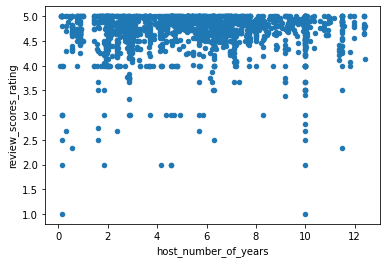

In [96]:
# number of host years VS. ratings/price
df_none_null.plot.scatter(x="host_number_of_years", y="review_scores_rating")

## host experience (years) VS. price

<AxesSubplot:xlabel='host_number_of_years', ylabel='price'>

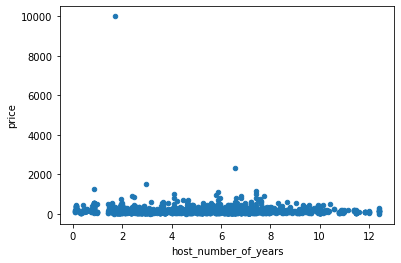

In [97]:
# number of host years VS. ratings/price
df_none_null.plot.scatter(x="host_number_of_years", y="price")

In [98]:
df_none_null.host_number_of_years.describe()

count    1678.000000
mean        5.509854
std         2.859154
min         0.073973
25%         2.964384
50%         5.695890
75%         7.164384
max        12.410959
Name: host_number_of_years, dtype: float64

(3.0, 5.0)

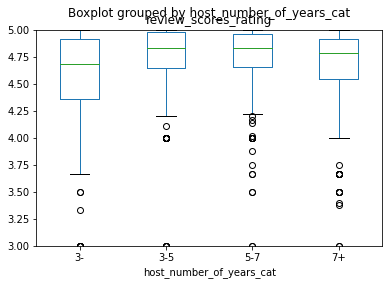

In [99]:
def categorize_years(year):
    if year>7:
        return "7+"
    if year>5:
        return "5-7"
    if year>3:
        return "3-5"
    else: return "3-"


df_none_null["host_number_of_years_cat"] = df_none_null["host_number_of_years"].map(categorize_years)

df_none_null.boxplot(by="host_number_of_years_cat", column=["review_scores_rating"], grid = False).set_ylim([3,5])

(0.0, 500.0)

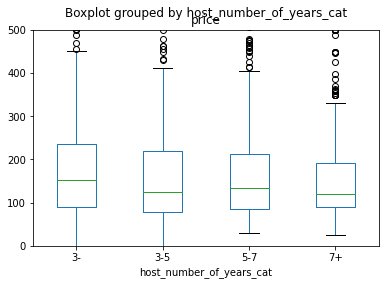

In [100]:

df_none_null.boxplot(by="host_number_of_years_cat", column=["price"], grid = False).set_ylim([0,500])

/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[(0.0, 300.0)]

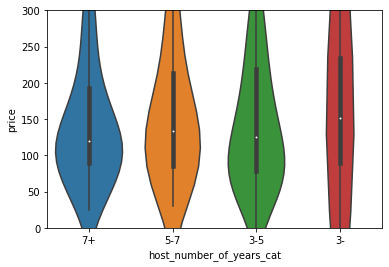

In [101]:
sns.violinplot("host_number_of_years_cat", "price", data=df_none_null).set(ylim=(0,300))

# neighborhood and pricing

/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[(0.0, 500.0), None]

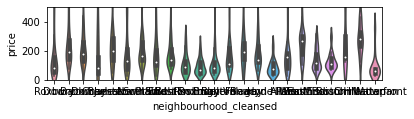

In [102]:
# neighbourhood_cleansed vs price
sns.violinplot("neighbourhood_cleansed", "price", data=df_none_null).set(ylim=(0,500),aspect=1/100)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

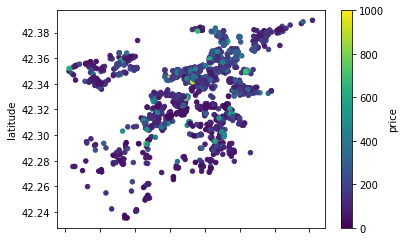

In [103]:
df_none_null = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 3)]
df_none_null.plot.scatter(x="longitude",y="latitude", c="price",colormap='viridis')

<AxesSubplot:>

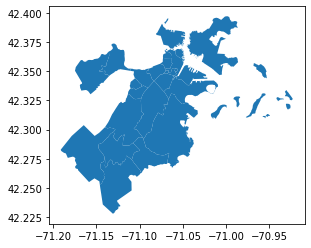

In [104]:
bostonGEO = gpd.read_file(neighbors_geojson_path)
bostonGEO.plot()

In [105]:
bostonGEO['neighbourhood'] #bostonGEO['geometry']

0                  Roslindale
1               Jamaica Plain
2                Mission Hill
3       Longwood Medical Area
4                 Bay Village
5            Leather District
6                   Chinatown
7                   North End
8                     Roxbury
9                   South End
10                   Back Bay
11                East Boston
12                Charlestown
13                   West End
14                Beacon Hill
15                   Downtown
16                     Fenway
17                   Brighton
18               West Roxbury
19                  Hyde Park
20                   Mattapan
21                 Dorchester
22    South Boston Waterfront
23               South Boston
24                    Allston
25             Harbor Islands
Name: neighbourhood, dtype: object

In [106]:
neighbourhoods_prices =[]
for i in bostonGEO['neighbourhood']:
    df_neighbour = df_none_null[df_none_null["neighbourhood_cleansed"]==i]
    # print(df_neighbour.shape)
    print(df_neighbour['price'].mean())
    to_append = df_neighbour['price'].mean()
    neighbourhoods_prices.append(to_append)
bostonGEO['price']=neighbourhoods_prices

90.96875
176.87719298245614
128.03846153846155
nan
169.97142857142856
nan
282.05
193.7948717948718
139.35135135135135
179.43410852713177
220.94495412844037
139.8235294117647
215.32692307692307
239.3125
198.54666666666665
231.60106382978722
235.23728813559322
112.30232558139535
108.61111111111111
86.44
88.57142857142857
127.40182648401826
262.4117647058824
181.09195402298852
164.03076923076924
nan


<AxesSubplot:>

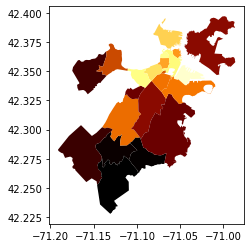

In [107]:
bostonGEO.plot(column='price', cmap='afmhot')

# host features and pricing

In [108]:
# fig, axes = plt.subplots(nrows=2, ncols=2)

# , ax=axes[0,0])

# host reposnse rate; remove % sign, convert to integer
df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt)
#  host_acceptance_rate:
df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt)




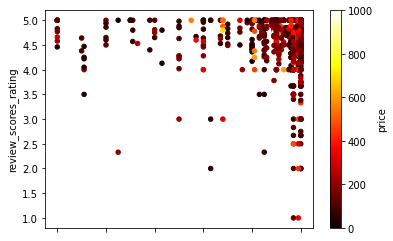

In [109]:
plot = df_none_null.plot.scatter(x="host_response_rate", y="review_scores_rating",
        c="price",colormap='hot')
# plot.set_xlim([80,102])
# plot.set_ylim([3.5,5])

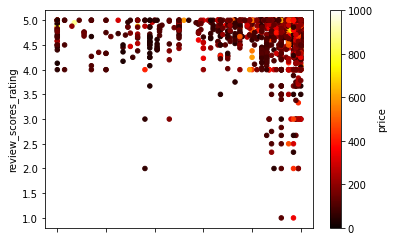

In [110]:
plot = df_none_null.plot.scatter(x="host_acceptance_rate", y="review_scores_rating",
        c="price",colormap='hot')

<AxesSubplot:title={'center':'price'}, xlabel='host_response_time'>

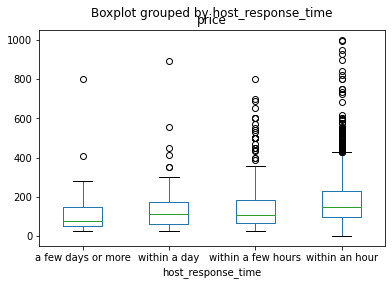

In [111]:
df_none_null.boxplot(by="host_response_time", column=["price"], grid = False)#.set_ylim([3.8,5])

(3.8, 5.0)

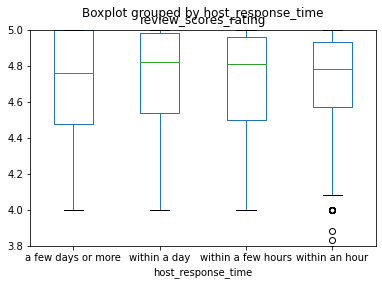

In [112]:
df_none_null.boxplot(by="host_response_time", column=["review_scores_rating"], grid = False).set_ylim([3.8,5])

<AxesSubplot:title={'center':'price'}, xlabel='host_is_superhost'>

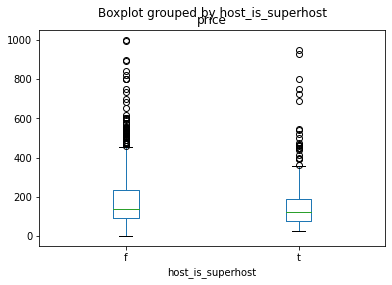

In [113]:
df_none_null.boxplot(by="host_is_superhost", column=["price"], grid = False)#.set_ylim([3.8,5])

(3.8, 5.0)

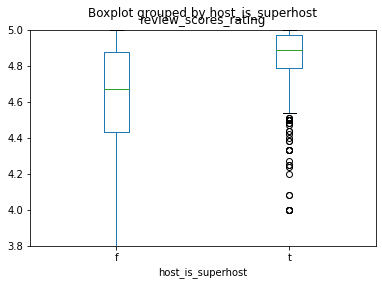

In [114]:
df_none_null.boxplot(by="host_is_superhost", column=["review_scores_rating"], grid = False).set_ylim([3.8,5])

In [115]:
# host_response_time
host_response_time_dummies = pd.get_dummies(df_none_null['host_response_time'],prefix='host_response_time_')
df_none_null = pd.concat([df_none_null,host_response_time_dummies], axis = 1)

# host_is_superhost: t/f to binary
df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary)
# "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount)
# "host_has_profile_pic" tf to binary
df_none_null['host_has_profile_pic'] = df_none_null['host_has_profile_pic'].map(trueFalseToBinary)
# "host_identity_verified",tf to binary
df_none_null['host_identity_verified'] = df_none_null['host_identity_verified'].map(trueFalseToBinary)

columns_of_interest_hosts = ["price", "review_scores_rating", 
                        "host_number_of_years", "host_response_rate","host_acceptance_rate",
                        # "host_response_time",
                        "host_is_superhost", "host_verifications",
                        #"host_has_profile_pic", "host_identity_verified"
                        ]
df_none_null[columns_of_interest_hosts]

,price,review_scores_rating,host_number_of_years,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications
1,145.0,4.77,12.400000,100,94,1,4
2,169.0,4.79,12.400000,100,94,1,4
3,76.0,4.78,11.980822,100,66,1,8
4,106.0,5.00,11.827397,99,14,1,8
8,111.0,4.30,11.484932,85,97,0,5
...,...,...,...,...,...,...,...
2975,148.0,4.00,2.043836,100,97,0,7
2981,138.0,5.00,0.131507,100,87,0,2
2982,131.0,3.00,0.131507,100,87,0,2
2987,201.0,5.00,8.076712,100,100,1,5


<AxesSubplot:>

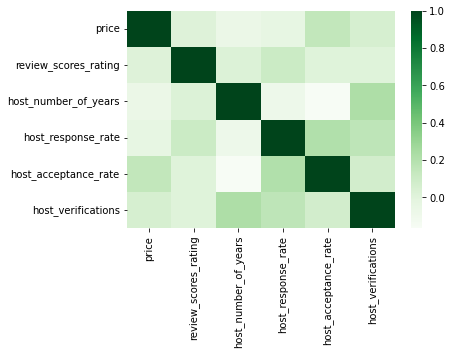

In [116]:
_df_interest = df_none_null[columns_of_interest_hosts]
sns.heatmap(_df_interest.corr(method='spearman'),cmap = 'Greens')

In [119]:
df_none_null['host_is_superhost'].astype('int32').corr(df_none_null['price'])

-0.1246013564333008

In [83]:
df_none_null[columns_of_interest_hosts]

,price,review_scores_rating,host_number_of_years,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified
1,145.0,4.77,12.400000,100,94,1,4,1,1
2,169.0,4.79,12.400000,100,94,1,4,1,1
3,76.0,4.78,11.980822,100,66,1,8,1,1
4,106.0,5.00,11.827397,99,14,1,8,1,1
8,111.0,4.30,11.484932,85,97,0,5,1,1
...,...,...,...,...,...,...,...,...,...
2975,148.0,4.00,2.043836,100,97,0,7,1,1
2981,138.0,5.00,0.131507,100,87,0,2,1,1
2982,131.0,3.00,0.131507,100,87,0,2,1,1
2987,201.0,5.00,8.076712,100,100,1,5,1,1


# patterns
- hosts with longer years doesn't necessarily have the best reviews ratings; lowest years tend to be more spread out
- hosts with more years tend to focus more on average priced units, where as beginner hosts are spread out on pricing.
- neighborhoods do vary quite significantly in pricing

## host features and pricing
- higher response rates and higher acceptance rate seem to command higher pricing?
- hosts with faster response times are commanding higher pricings in all quantiles ; but not necessarily better review scores
- super hosts offer a much condensed range of pricing and lower pricings; and have a tighter range of review scores; and higher median review scores
- "host_has_profile_pic", "host_identity_verified" are useless; lacking variance


In [ ]:
# # host_is_superhost: t/f to binary
# df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary)
# # "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount)
# "host_has_profile_pic" tf to binary
# df_none_null['host_has_profile_pic'] = df_none_null['host_has_profile_pic'].map(trueFalseToBinary)
# # "host_identity_verified",tf to binary
# df_none_null['host_identity_verified'] = df_none_null['host_identity_verified'].map(trueFalseToBinary)


# Combined: Processing all variables of concern

In [185]:
_features_none_null = ["id","host_id","host_since","host_response_rate","host_acceptance_rate",
                        "host_response_time",
                        "host_is_superhost", "host_verifications",
                        "host_has_profile_pic", "host_identity_verified",
                        "neighbourhood_cleansed", "latitude", "longitude",
                        "room_type", "accommodates", "amenities", "price", "minimum_nights", 
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",	"review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "instant_bookable", 
                        ]

reference_date = datetime.datetime(2021,7,12)
# adding custom: host_number_of_years
host_number_of_years = [(reference_date - datetime.datetime.strptime(i, '%Y-%m-%d')).days/365
                        for i in df_none_null['host_since']]
df_none_null["host_number_of_years"] = host_number_of_years
df_none_null['price'] = df_none_null['price'].map(lambda x:float(x[1:].replace(',', ''))).astype('int32')


# host reposnse rate; remove % sign, convert to integer
df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt).astype('int32')
#  host_acceptance_rate:
df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt).astype('int32')

# TODO host_response_time; arbitrary or one-hot
# df_none_null['host_response_time']= df_none_null['host_response_time'].map({
#     'within an hour':1, 'within a day':3, 'within a few hours':2,
#        'a few days or more':4
# })
host_response_time_dummies = pd.get_dummies(df_none_null['host_response_time'],prefix='host_response_time_')
df_none_null = pd.concat([df_none_null,host_response_time_dummies], axis = 1)

# host_is_superhost: t/f to binary
df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary).astype('int32')
# "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount).astype('int32')
# "host_has_profile_pic" tf to binary
df_none_null['host_has_profile_pic'] = df_none_null['host_has_profile_pic'].map(trueFalseToBinary).astype('int32')
# "host_identity_verified",tf to binary
df_none_null['host_identity_verified'] = df_none_null['host_identity_verified'].map(trueFalseToBinary).astype('int32')

# TODO "neighbourhood_cleansed"

# "latitude" pass
# "longitude", pass

# "room_type" ['Entire home/apt'4 'Private room'2 'Shared room'1 'Hotel room'3]
df_none_null['room_type'] = df_none_null['room_type'].map(
                            {'Entire home/apt':4,
                                'Private room':2,
                                 'Shared room':1,
                                  'Hotel room':3})

# "accommodates", pass
#  "amenities", 
df_none_null['amenities'] = df_none_null['amenities'].map(stringListToCount).astype('int32')
# "price", pass

# TODO "minimum_nights", to categorical? 3 categories [short medium long?]
# df_none_null['minimum_nights'] = df_none_null['minimum_nights']

# "availability_30",
df_none_null['availability_30'] = df_none_null['availability_30']/30.0
# "availability_60",
df_none_null['availability_60'] = df_none_null['availability_60']/60.0
# "availability_90",
df_none_null['availability_90'] = df_none_null['availability_90']/90.0
# "availability_365", 
df_none_null['availability_365'] = df_none_null['availability_365']/365.0

# "number_of_reviews" pass,

# all pass
# "review_scores_rating", 
# "review_scores_accuracy",
# "review_scores_cleanliness",
# 	"review_scores_checkin",	
# "review_scores_communication",
# "review_scores_location",
# 	"review_scores_value",

# "instant_bookable", 
df_none_null['instant_bookable'] = df_none_null['instant_bookable'].map(trueFalseToBinary).astype('int32')


/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_53831/1037707787.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt)
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_53831/1037707787.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt)
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_53831/10377